# **Driver Drowsiness Detection Project**
# **Project Overview**
## Driver drowsiness is a major safety concern, contributing to numerous road accidents worldwide.
## This deep learning project aims to detect when drivers are becoming drowsy, potentially preventing fatal accidents.

# **Approach**
## The project utilizes a  deep learning architecture that combines:
* ## Transfer Learning: Using MobileNetV2 pre-trained on ImageNet
* ## Deep Neural Networks: Combining convolutional, dense, and LSTM layers

# **Outcomes**
* ## Binary classification of driver state
* ## Confusion matrix
* ## Accuracy and performance metrics


# **Import Libraries and Setup**

## Imports all the necessary Python libraries for data manipulation, machine learning, deep learning, and visualization. The libraries include TensorFlow, Keras, scikit-learn, and others that will be used throughout the project.

In [1]:
!pip install split-folders

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders  
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, LSTM, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.utils import plot_model
import IPython.display
import glob
import warnings
warnings.filterwarnings('ignore')

# **Data Preparation and Splitting**

## Sets up the data directories and uses the splitfolders library to automatically split the driver drowsiness dataset into training (80%), testing (15%), and validation (5%) sets. This ensures a proper distribution of data for model training and evaluation.

In [3]:
data_dir = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)'
output_dir = '/kaggle/working/splitted_Data'

os.makedirs(output_dir, exist_ok=True)
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(0.8, 0.15, 0.05))


train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
val_dir = os.path.join(output_dir, "val")

Copying files: 41793 files [04:11, 166.42 files/s]


# **Image Data Generators**

## Creates image data generators that will load and preprocess the images. The generators:

* ### Rescale pixel values to the range [0, 1]
* ### Resize images to 128x128 pixels
* ### Use binary classification mode
* ### Set batch size to 16
* ### Shuffle training and validation data

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=16, class_mode='binary', shuffle=True)
test_batches = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=16, class_mode='binary', shuffle=False)
val_batches = val_datagen.flow_from_directory(val_dir, target_size=(128, 128), batch_size=16, class_mode='binary', shuffle=True)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


# **Dataset Size Analysis**

## Counts the number of images in each dataset split (total, training, validation, and test).
## It provides insight into the dataset's size and distribution.

In [5]:
def count_images_in_directory(directory):
    return len(glob.glob(os.path.join(directory, "*/*.jpg")) + 
               glob.glob(os.path.join(directory, "*/*.jpeg")) + 
               glob.glob(os.path.join(directory, "*/*.png")))


len_all_dirs = count_images_in_directory(data_dir)
len_train_paths = count_images_in_directory(train_dir)
len_val_paths = count_images_in_directory(val_dir)
len_test_paths = count_images_in_directory(test_dir)


print(f"Total images: {len_all_dirs}")
print(f"Training set: {len_train_paths} images")
print(f"Validation set: {len_val_paths} images")
print(f"Test set: {len_test_paths} images")

Total images: 41793
Training set: 33434 images
Validation set: 6268 images
Test set: 2091 images


 # **Image Preprocessing**

## Prepares individual images for the model by resizing, converting to array, and normalizing pixel values.

In [6]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# **Visualize Training Images**

## Creates a grid of sample images from the training dataset, displaying both the images and their corresponding labels (Awake or Drowsy). 
## This helps in understanding the dataset's visual characteristics.

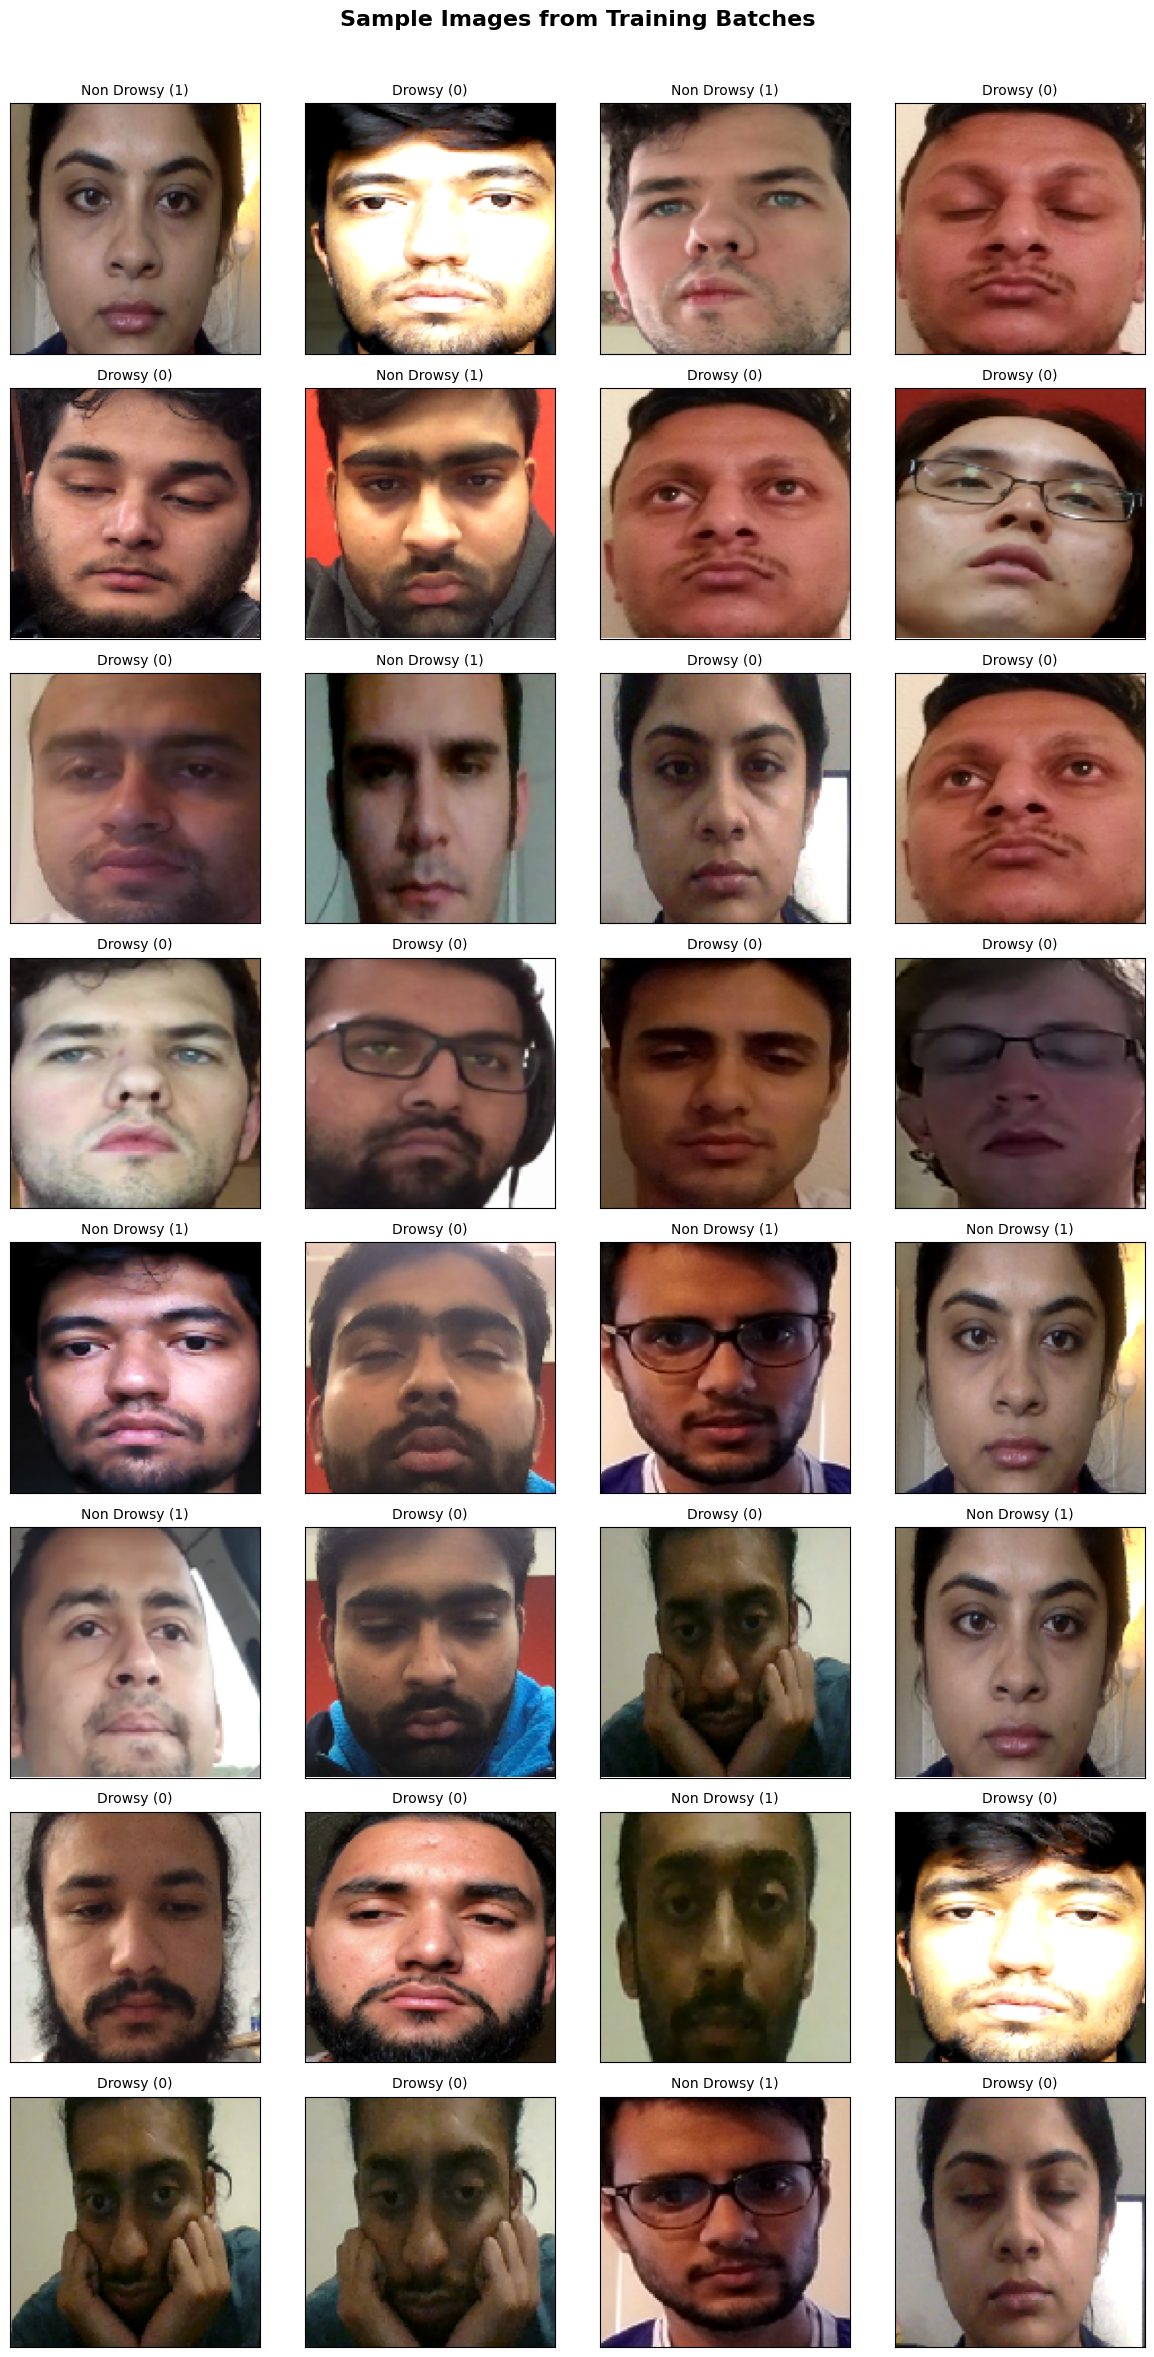

In [7]:
ig, axes = plt.subplots(8, 4, figsize=(12, 24))
class_indices = train_batches.class_indices

for i in range(8):  
    images, labels = next(train_batches)  
    
    for j in range(min(4, len(images))):  
        ax = axes[i, j] 
        ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])
        
       
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})', fontsize=10)


plt.suptitle("Sample Images from Training Batches", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# **Model Architecture**

## Defines the neural network architecture:

* ### Uses MobileNetV2 as a pre-trained base model for feature extraction
* ### Adds custom layers including dense layers, batch normalization, dropout
* ### Incorporates an LSTM layer for sequence processing
* ### Outputs a sigmoid activation for binary classification (Awake/Drowsy) 

In [8]:
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(128, 128, 3)
)
base_model.trainable = False  # Initially freeze

x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

lstm_input = tf.keras.layers.Reshape((1, 128))(x)
lstm_output = LSTM(128, return_sequences=False)(lstm_input)
dense_output = Dense(1, activation='sigmoid')(lstm_output)

model = Model(inputs=base_model.input, outputs=dense_output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Model Compilation and Training**


* ### Compiles the model with Adam optimizer and binary cross-entropy loss
* ### Sets up early stopping to prevent overfitting
* ### Implements learning rate reduction to help convergence
* ### Trains the model for up to 10 epochs

In [9]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)


early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=3, 
    min_lr=0.000001
)

In [10]:
history = model.fit(
    train_batches, 
    validation_data=val_batches, 
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 137s 61ms/step - accuracy: 0.6266 - loss: 0.6584 - val_accuracy: 0.9258 - val_loss: 0.4364 - learning_rate: 1.0000e-05
Epoch 2/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 125s 60ms/step - accuracy: 0.8743 - loss: 0.4537 - val_accuracy: 0.9879 - val_loss: 0.1674 - learning_rate: 1.0000e-05
Epoch 3/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 124s 59ms/step - accuracy: 0.9494 - loss: 0.2330 - val_accuracy: 0.9966 - val_loss: 0.0605 - learning_rate: 1.0000e-05
Epoch 4/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 124s 59ms/step - accuracy: 0.9715 - loss: 0.1222 - val_accuracy: 0.9978 - val_loss: 0.0276 - learning_rate: 1.0000e-05
Epoch 5/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 124s 59ms/step - accuracy: 0.9805 - loss: 0.0775 - val_accuracy: 0.9982 - val_loss: 0.0155 - learning_rate: 1.0000e-05
Epoch 6/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 124s 59ms/step - accuracy: 0.9828 - loss: 0.0602 - val_accuracy: 0.9990 - val_loss: 0.0098 - learning_rate: 1.0000e-05
Epoch 7/10
2090/2090 ━━━━━━━━━━━━━

# **Model Architecture Visualization**

## Display a layer-wise summary and a graphical representation of the model architecture, showing layer connections and tensor shapes.

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,738,693 (14.26 MB)

 Trainable params: 493,313 (1.88 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

 Optimizer params: 986,628 (3.76 MB)

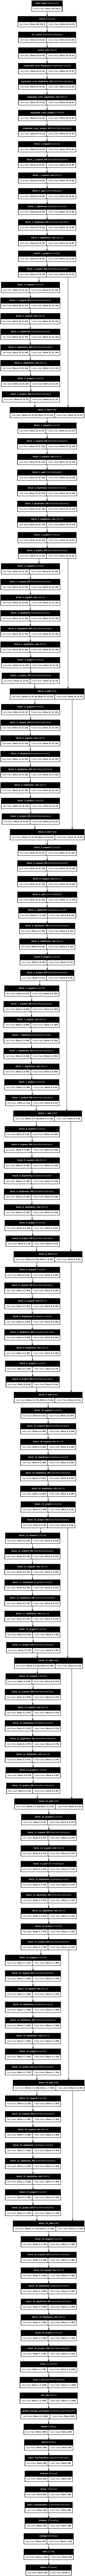

In [12]:
plot_model(
    model, 
    show_shapes=True, 
    show_layer_names=True,
    dpi=100
)

# **Model Evaluation**

# Helps in evaluating the model's accuracy in detecting driver drowsiness by:
* ### Printing a detailed classification report with precision, recall, and F1-score.
* ### Visualizing a confusion matrix to assess model performance.


In [13]:
y_true = test_batches.classes
y_pred = model.predict(test_batches)
y_pred = (y_pred > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1118
           1       1.00      1.00      1.00       973

    accuracy                           1.00      2091
   macro avg       1.00      1.00      1.00      2091
weighted avg       1.00      1.00      1.00      2091



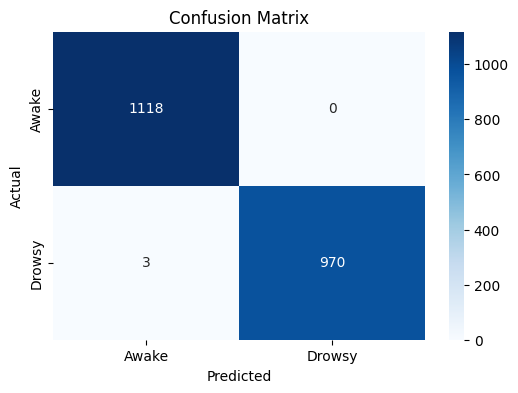

In [14]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Awake', 'Drowsy'], yticklabels=['Awake', 'Drowsy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()